# Classifying if a banck customers is risky or non-risky with the ML methods of Random Forest, XGBoost and CatBoost 
_**Supervised Learning with Gradient Boosted Trees and Random Forest: A Binary Prediction Problem**_

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Random Forest classifier](#Random_Forest_classifier)
    1. [Training](#Training)
    1. [Tuning](#Tuning)
    1. [Testing](#Testing)
1. [XGB classifier](#XGB_classifier)
    1. [Training](#Training)
    1. [Tuning](#Tuning)
    1. [Testing](#Testing)
1. [CatBoost classifier](#CatBoost_classifier)
    1. [Training](#Training)
    1. [Tuning](#Tuning)
    1. [Testing](#Testing)
1. [Results](#Results)
  

---

## Background
In 2006 Taiwan faced a credit card crisis. In order to increse market share, card-issuing banks in Taiwan over-issued cash and credit cards to unqualified applicants. At the same time, most cardholders, irrespective of their repayment ability, overused credit card for consumption and accumulated heavy credit and cash–card debts. The crisis caused the blow to consumer finance confidence and it is a big challenge for both banks and cardholders.

source:" The comparisons of data mining techniques for the predictiveaccuracy of probability of default of credit card clients. I-Cheng Yeh , Che-hui Lien". 
Department of Information Management, Chung-Hua University, Hsin Chu 30067, Taiwan. 
ROC, Department of Management, Thompson Rivers University, Kamloops, BC, Canad.

This notebook presents an example problem to predict if a customer will be a risky client for a bank that have to decide if giving or not a credit card.

## Preparation

Let's bring the python library that I will use throughout the analysis

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scikitplot as skplt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from catboost import CatBoostClassifier

## Data

data source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [2]:
dt = pd.read_excel("default of credit card clients.xls",index_col=0, header=1)
dt=dt.rename(columns = {'PAY_0':'PAY_1'}) # correcting the name of PAY_0 to PAY_1
dt

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [5]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

I decided to convert the categorical features type from numeric to object with the aim of correct data visualizzation

In [3]:
convert_dict = {'SEX': object,
                'EDUCATION': object,
                'MARRIAGE': object,
                'default payment next month': object,
                'PAY_1':object,
                'PAY_2':object,
                'PAY_3':object,
                'PAY_4':object,
                'PAY_5':object,
                'PAY_6':object}
 
dt = dt.astype(convert_dict)
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   30000 non-null  int64 
 1   SEX                         30000 non-null  object
 2   EDUCATION                   30000 non-null  object
 3   MARRIAGE                    30000 non-null  object
 4   AGE                         30000 non-null  int64 
 5   PAY_1                       30000 non-null  object
 6   PAY_2                       30000 non-null  object
 7   PAY_3                       30000 non-null  object
 8   PAY_4                       30000 non-null  object
 9   PAY_5                       30000 non-null  object
 10  PAY_6                       30000 non-null  object
 11  BILL_AMT1                   30000 non-null  int64 
 12  BILL_AMT2                   30000 non-null  int64 
 13  BILL_AMT3                   30000 non-null  in

Let's talk about the data.  At a high level, we can see:

* We have 30K credit card client, and 23 features for each customer
* The features are all numeric

_**Specific in each of the features**_

*Demographics:*
* `Sex`: Client gender, male=1 or female=2,
* `Education`: Client level of education, 1 = graduate school; 2 = university;3 = high school; 4 = others,
* `Marriage`: Client marital status, 1 = married; 2 = single; 3 = others,
* `Age`: age in year.

*Past finacial history*
* `Pay_1 to Pay_6`: History of past payment from month 1 that is april to month 6 that is september. Each feture can take value from -1 = pay duly to 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above,
* `Bill_AMT1 to Bill_AMT6`: Amount of bill statement (NT dollar) from april (Bill_AMT1) to september (Bill_AMT6),
* `Pay_AMT1 to Pay_AMT6`: Amount of previous payment (NT dollar) from april (Pay_AMT1) to september (Pay_AMT6).

*Target*
* `default payment next month`: Yes = 1, No = 0.

## Exploration

Let's see how the features are distributed

col_0,% observations
SEX,
1,0.396267
2,0.603733


col_0,% observations
EDUCATION,
0,0.000467
1,0.352833
2,0.467667
3,0.163900
4,0.004100
5,0.009333
6,0.001700


col_0,% observations
MARRIAGE,
0,0.001800
1,0.455300
2,0.532133
3,0.010767


col_0,% observations
PAY_1,
-2,0.091967
-1,0.189533
0,0.491233
1,0.122933
2,0.088900
3,0.010733
4,0.002533
5,0.000867
6,0.000367


col_0,% observations
PAY_2,
-2,0.126067
-1,0.201667
0,0.524333
1,0.000933
2,0.130900
3,0.010867
4,0.003300
5,0.000833
6,0.000400


col_0,% observations
PAY_3,
-2,0.136167
-1,0.197933
0,0.525467
1,0.000133
2,0.127300
3,0.008000
4,0.002533
5,0.000700
6,0.000767


col_0,% observations
PAY_4,
-2,0.144933
-1,0.189567
0,0.548500
1,0.000067
2,0.105300
3,0.006000
4,0.002300
5,0.001167
6,0.000167


col_0,% observations
PAY_5,
-2,0.151533
-1,0.184633
0,0.564900
2,0.087533
3,0.005933
4,0.002800
5,0.000567
6,0.000133
7,0.001933


col_0,% observations
PAY_6,
-2,0.163167
-1,0.191333
0,0.542867
2,0.092200
3,0.006133
4,0.001633
5,0.000433
6,0.000633
7,0.001533


col_0,% observations
default payment next month,
0,0.7788
1,0.2212


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


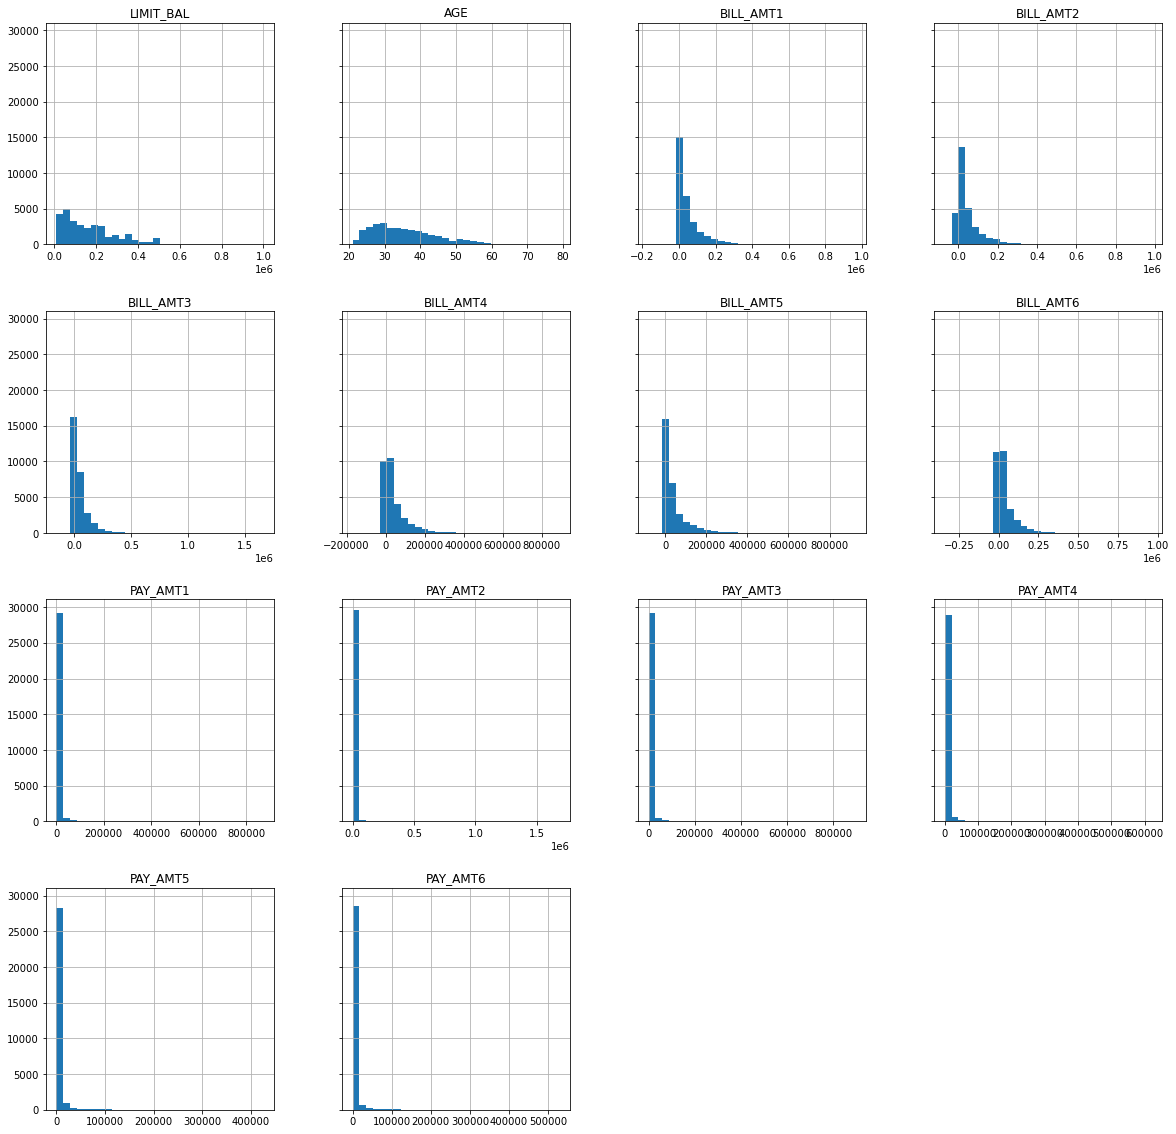

In [4]:
# Frequency tables for each categorical feature
for column in dt.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=dt[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(dt.describe())
%matplotlib inline
hist = dt.hist(bins=30, sharey=True, figsize=(20, 20))

Notice that:

* There are some value that aren't described in the paper of the dataset. For example Pay take the value of -2 that isn't explained.
* Also Marriage and education have another category that isn't explained. I decided to inputate the category not described in 'others'.
* The peroportion of peaple that were default is 0.2212.
* The feature Pay_amt present very different values, the grat majority of this values are less that 50k dollars wile there are some values that goes over 1kk up to 5kk

Next, let's look at how our features relate to the target that we are attempting to predict.

default payment next month,0,1
SEX,,
1,0.38585,0.432942
2,0.61415,0.567058


default payment next month,0,1
EDUCATION,,
0,0.000599,0.000000
1,0.365905,0.306811
2,0.457970,0.501808
3,0.157507,0.186407
4,0.004965,0.001055
5,0.011214,0.002712
6,0.001840,0.001206


default payment next month,0,1
MARRIAGE,,
0,0.002097,0.000753
1,0.447398,0.483122
2,0.540276,0.503466
3,0.010229,0.012658


default payment next month,0,1
PAY_1,,
-2,0.102465,0.055003
-1,0.202534,0.143761
0,0.549949,0.284509
1,0.104263,0.188668
2,0.035225,0.277878
3,0.003338,0.036769
4,0.001027,0.007836
5,0.000556,0.001959
6,0.000214,0.000904


default payment next month,0,1
PAY_2,,
-2,0.132298,0.104129
-1,0.217600,0.145570
0,0.566127,0.377185
1,0.000984,0.000753
2,0.074602,0.329114
3,0.005350,0.030289
4,0.002097,0.007535
5,0.000428,0.002260
6,0.000128,0.001356


default payment next month,0,1
PAY_3,,
-2,0.142441,0.114075
-1,0.214518,0.139542
0,0.556968,0.414557
1,0.000128,0.000151
2,0.079182,0.296715
3,0.004366,0.020796
4,0.001370,0.006631
5,0.000385,0.001808
6,0.000385,0.002110


default payment next month,0,1
PAY_4,,
-2,0.150274,0.126130
-1,0.204717,0.136227
0,0.575201,0.454491
1,0.000043,0.000151
2,0.064458,0.249096
3,0.002996,0.016576
4,0.000984,0.006932
5,0.000728,0.002712
6,0.000128,0.000301


default payment next month,0,1
PAY_5,,
-2,0.156266,0.134870
-1,0.198682,0.135172
0,0.588598,0.481465
2,0.051489,0.214436
3,0.002782,0.017028
4,0.001412,0.007685
5,0.000300,0.001507
6,0.000043,0.000452
7,0.000428,0.007233


default payment next month,0,1
PAY_6,,
-2,0.167523,0.147830
-1,0.203946,0.146926
0,0.565699,0.462477
2,0.058423,0.211121
3,0.002825,0.017782
4,0.000770,0.004671
5,0.000257,0.001055
6,0.000214,0.002110
7,0.000342,0.005726


LIMIT_BAL


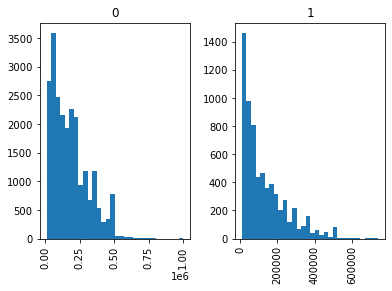

AGE


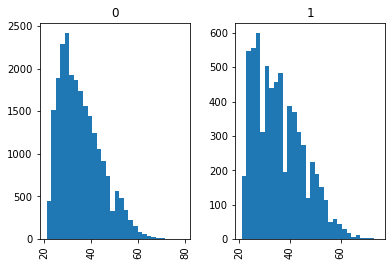

BILL_AMT1


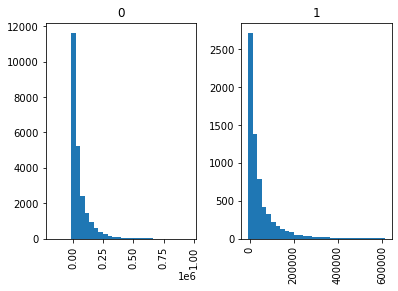

BILL_AMT2


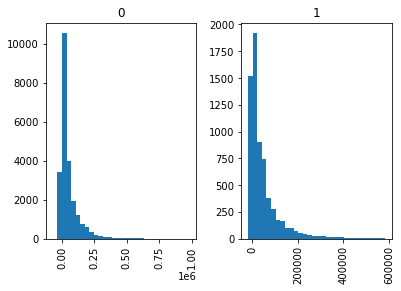

BILL_AMT3


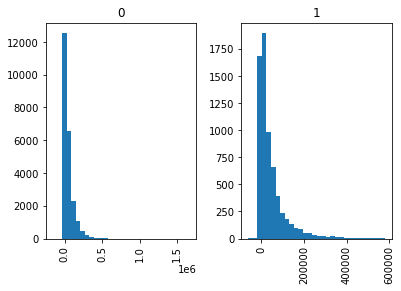

BILL_AMT4


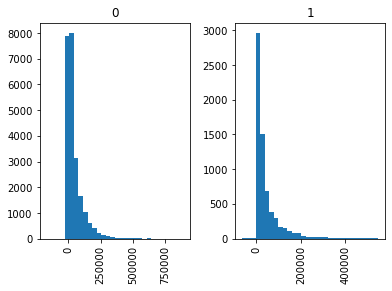

BILL_AMT5


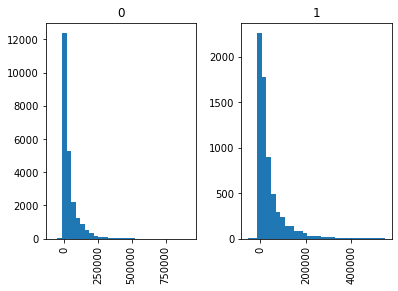

BILL_AMT6


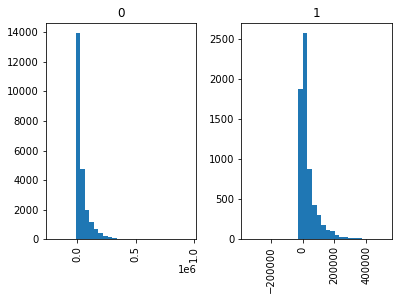

PAY_AMT1


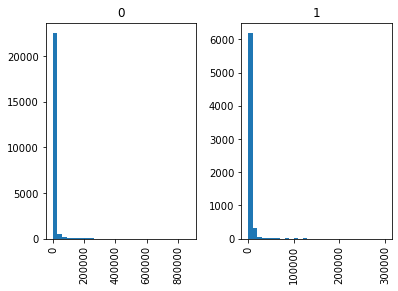

PAY_AMT2


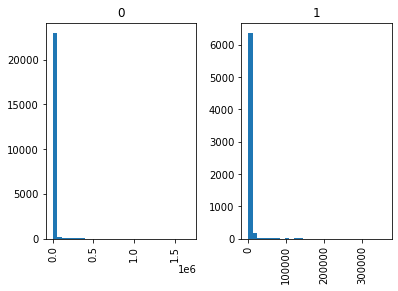

PAY_AMT3


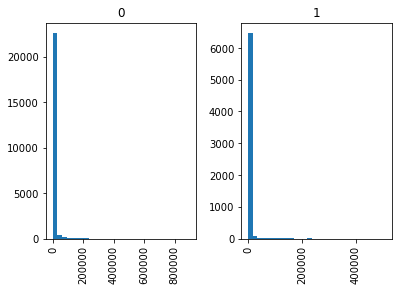

PAY_AMT4


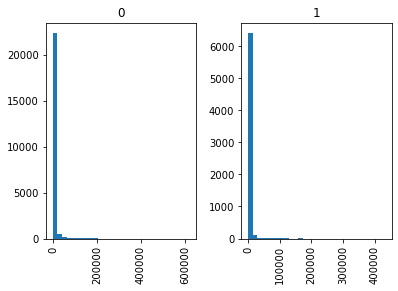

PAY_AMT5


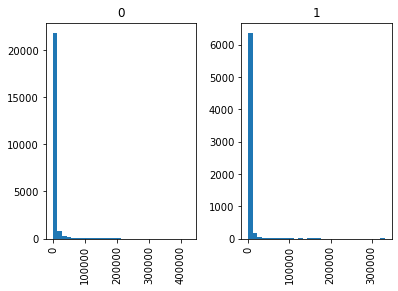

PAY_AMT6


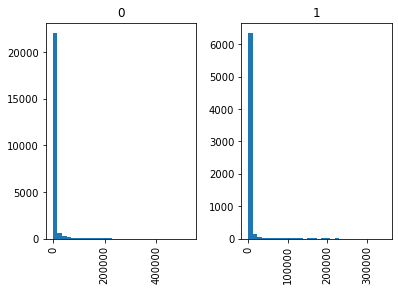

In [40]:
for column in dt.select_dtypes(include=['object']).columns:
    if column != 'default payment next month':
        display(pd.crosstab(index=dt[column], columns=dt['default payment next month'], normalize='columns'))

for column in dt.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = dt[[column, 'default payment next month']].hist(by='default payment next month', bins=30)
    plt.show()

<AxesSubplot:xlabel='PAY_1'>

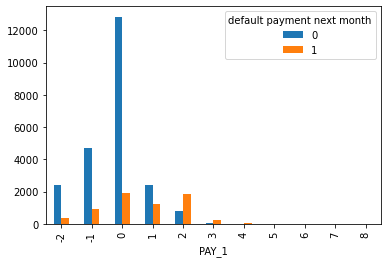

In [27]:
pd.crosstab(index=dt['PAY_1'], columns=dt['default payment next month']).plot.bar()

<AxesSubplot:xlabel='PAY_2'>

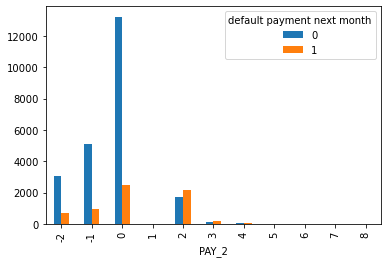

In [28]:
pd.crosstab(index=dt['PAY_2'], columns=dt['default payment next month']).plot.bar()

<AxesSubplot:xlabel='PAY_3'>

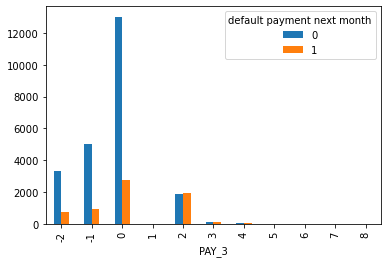

In [29]:
pd.crosstab(index=dt['PAY_3'], columns=dt['default payment next month']).plot.bar()

Notice that:
* Education, Marriage, Age and sex doesn't seems to have any ralation with the target variable
* Pay seems to show some informations. In particular the payment status (that is difficult to interpt beacuse of the lack on information for categort 0 and -2) shows that with the incrising delay in the bill payment increase the rate of peaople that are default
* Moreover BILL_AMT shows that tha rate of default peaople increse with the amount of bill statement


In [31]:
display(dt.corr())

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.144713,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595
AGE,0.144713,1.000000,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478
BILL_AMT1,0.285430,0.056239,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341
BILL_AMT2,0.278314,0.054283,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256
BILL_AMT3,0.283236,0.053710,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320,0.244335,0.316936,0.130011,0.143405,0.179712,0.182326
BILL_AMT4,0.293988,0.051353,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941,0.233012,0.207564,0.300023,0.130191,0.160433,0.177637
BILL_AMT5,0.295562,0.049345,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197,0.217031,0.181246,0.252305,0.293118,0.141574,0.164184
BILL_AMT6,0.290389,0.047613,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000,0.199965,0.172663,0.233770,0.250237,0.307729,0.115494
PAY_AMT1,0.195236,0.026147,0.140277,0.280365,0.244335,0.233012,0.217031,0.199965,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735
PAY_AMT2,0.178408,0.021785,0.099355,0.100851,0.316936,0.207564,0.181246,0.172663,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634


Notice that:
* Bill_Amt shows a strong correlation structure. That's obvious because of the amount of bill during a time period is correlated with it self
* The others correlation are all positive and with out a strong significativity

### Transformation
* Groupping elements in less category for marriage and education
* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* Oddly distributed data: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.

In [6]:
for i in range(1,30000):
    if (dt['EDUCATION'][i]==5) | (dt['EDUCATION'][i]==0) | (dt['EDUCATION'][i]==6):
        dt['EDUCATION'][i]=4
display(pd.crosstab(index=dt['EDUCATION'], columns=' observations'))

col_0,observations
EDUCATION,
1,10585
2,14030
3,4917
4,468


In [7]:
for i in range(1,30000):
    if (dt['MARRIAGE'][i]==0):
        dt['MARRIAGE'][i]=3
display(pd.crosstab(index=dt['MARRIAGE'], columns='% observations'))

col_0,% observations
MARRIAGE,
1,13659
2,15964
3,377


In [6]:
dt = dt.astype({'default payment next month': int})

In [7]:
model_dt = pd.get_dummies(dt, columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
model_dt.reset_index(drop=True, inplace=True)
model_dt = model_dt.astype('int')

In [8]:
seed=589667
train_data, validation_data, test_data = np.split(model_dt.sample(frac=1, random_state=seed), [int(0.7 * len(model_dt)), int(0.9 * len(model_dt))])

In [9]:
# Separating target from train data
y_tr = train_data['default payment next month']
x_tr =train_data.drop('default payment next month',axis=1)
# Separating target from validation data
y_v = validation_data['default payment next month']
x_v =validation_data.drop('default payment next month',axis=1)
# Separating target from test data
y_t = test_data['default payment next month']
x_t =test_data.drop('default payment next month',axis=1)

## Random Forest classifier

To evaluate the performance of my classifier i decide to use the accuracy, balanced accuracy and the False Negative rate. The last metric is important beacause for a banck is a more expansive error to give a cridit card to a person that will be default than doesn't giving any credit card. So the false negative rate help to monitoring this kind of error

In [82]:
forest_1=RandomForestClassifier(n_estimators=100,  criterion='entropy', max_features='log2', n_jobs=-1, random_state=seed)

### Training

In [83]:
forest_1.fit(x_tr, y_tr)

RandomForestClassifier(criterion='entropy', max_features='log2', n_jobs=-1,
                       random_state=589667)

Accuracy score: 0.8123
Balanced accuracy score: 0.6448
False negative rate: 0.6700


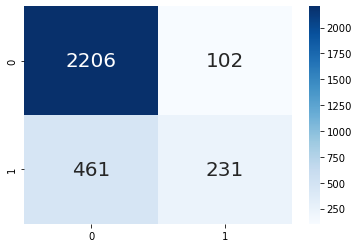

In [84]:
y_pred = forest_1.predict(x_t)
cm = confusion_matrix(y_t, y_pred)
tn, fp, fn, tp = confusion_matrix(y_t, y_pred).ravel()

sns.heatmap(cm, cmap="Blues", fmt='g', annot=True, annot_kws={"size": 20})
print('Accuracy score: {0:0.4f}'. format(accuracy_score(y_t, y_pred)))
print('Balanced accuracy score: {0:0.4f}'. format(balanced_accuracy_score(y_t, y_pred)))
print('False negative rate: {0:0.4f}'. format(round(fn / (fn + tp), 2)))

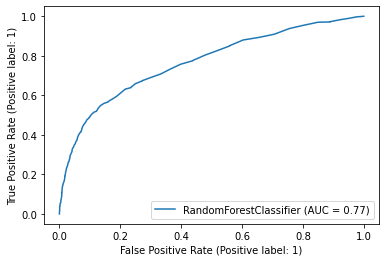

In [85]:
roc_curve = RocCurveDisplay.from_estimator(forest_1, x_t, y_t)
plt.show()

Notice that our classifier has some problem to predict the person that are actually default. We could try to emprouve his performance with tuning and also adding class weight.

### Tuning

In [86]:
scores =[]
for k in range(200, 1000, 100):
    rfr = RandomForestClassifier(n_estimators=k,  criterion='entropy', max_features='log2', class_weight='balanced', n_jobs=-1, random_state=seed)
    rfr.fit(x_tr, y_tr)
    y_pred = rfr.predict(x_v)
    scores.append(roc_auc_score(y_v, rfr.predict_proba(x_v)[:,1]))


Text(0, 0.5, 'Punteggio AUC')

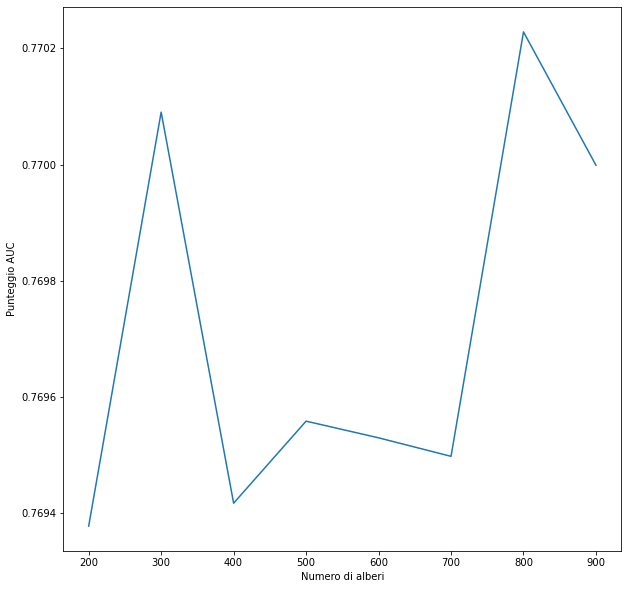

In [88]:
plt.figure(figsize=(10, 10))
plt.plot(range(200, 1000, 100), scores)
plt.xlabel('Numero di alberi')
plt.ylabel('Punteggio AUC')


### Testing

In [10]:
forest_2=RandomForestClassifier(n_estimators=800, criterion='entropy', max_features='log2', class_weight='balanced', n_jobs=-1, random_state=seed)
forest_2.fit(x_tr, y_tr)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=800, n_jobs=-1,
                       random_state=589667)

Accuracy score: 0.8137
Balanced accuracy score: 0.6467
False negative rate: 0.6600


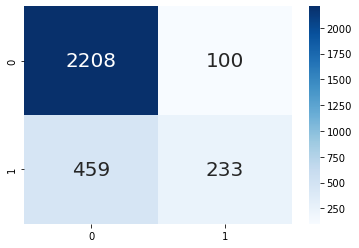

In [14]:
y_pred2 = forest_2.predict(x_t)
cm = confusion_matrix(y_t, y_pred2)
tn, fp, fn, tp = confusion_matrix(y_t, y_pred2).ravel()

sns.heatmap(cm, cmap="Blues", fmt='g', annot=True, annot_kws={"size": 20})
acc_f=accuracy_score(y_t, y_pred2)
acc_bf=balanced_accuracy_score(y_t, y_pred2)
fn_f=round(fn / (fn + tp), 2)
print('Accuracy score: {0:0.4f}'. format(acc_f))
print('Balanced accuracy score: {0:0.4f}'. format(acc_bf))
print('False negative rate: {0:0.4f}'. format(fn_f))

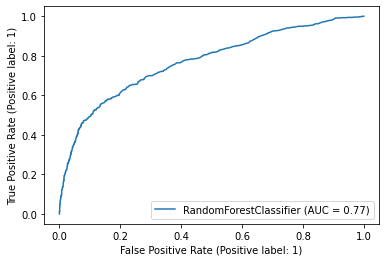

In [12]:
best_fr = RocCurveDisplay.from_estimator(forest_2, x_t, y_t)
plt.show()

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation 
of the impurity decrease within each tree.

In [101]:
res=permutation_importance(forest_2, x_tr, y_tr, scoring='roc_auc', random_state=seed)

In [112]:
importance=pd.DataFrame(data=res.importances_mean, index=x_tr.columns, columns=['importances mean'])
importance['importances std']=res.importances_std
importance=importance.sort_values('importances mean', ascending=False)
imp_10=importance.head(10)

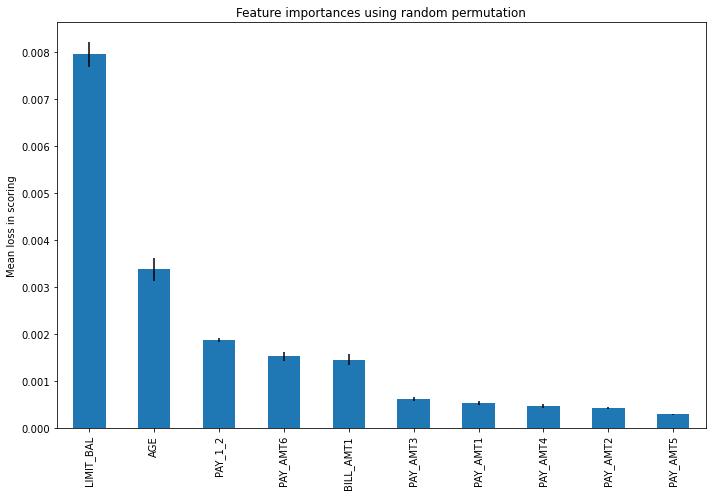

In [118]:
forest_importances = pd.Series(imp_10['importances mean'].values, index=imp_10.index)
fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=imp_10['importances std'].values, ax=ax)
ax.set_title("Feature importances using random permutation")
ax.set_ylabel("Mean loss in scoring")
fig.tight_layout()

Notice that:
* The most important feature for trainig model is Limit_Bal followed by Age and the stae of payment at semptember when a customer is in delay of 2 months.
* Age gived some unexpected results becouse of from the exploratory analysis didn't rise any suggest about the correlation with the target.

## XGB classifier

In [17]:
Y=model_dt['default payment next month']
X=model_dt.drop('default payment next month',axis=1)
x_tr, x_t, y_tr, y_t = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [16]:
f,t=dt['default payment next month'].value_counts()
weight=f/t
weight

3.5207956600361663

## Training

In [148]:
clas_xgb = xgb.XGBClassifier(eta=0.2, gamma=0, subsample=0.8, max_depth=6, learning_rate=0.2, silent=0, objective='binary:logistic', scale_pos_weight=weight, _label_encoder=False, num_round=100, random_state=seed)
clas_xgb.fit(x_tr, y_tr)

[15:56:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "_label_encoder", "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:56:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(_label_encoder=False, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, eta=0.2, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, num_round=100,
              predictor='auto', random_state=589667, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.5207956600361663, silent=0, subsample=0.8,
              tree_method='exact', ...)

Accuracy score: 0.7717
Balanced accuracy score: 0.7003
False negative rate: 0.4300


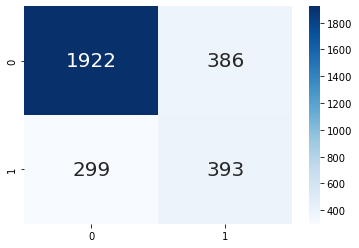

In [150]:
y_pred3 = clas_xgb.predict(x_t)
cm = confusion_matrix(y_t, y_pred3)
tn, fp, fn, tp = confusion_matrix(y_t, y_pred3).ravel()

sns.heatmap(cm, cmap="Blues", fmt='g', annot=True, annot_kws={"size": 20})
print('Accuracy score: {0:0.4f}'. format(accuracy_score(y_t, y_pred3)))
print('Balanced accuracy score: {0:0.4f}'. format(balanced_accuracy_score(y_t, y_pred3)))
print('False negative rate: {0:0.4f}'. format(round(fn / (fn + tp), 2)))

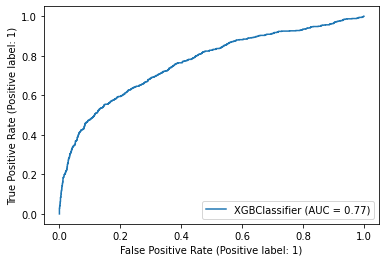

In [151]:
best_fr = RocCurveDisplay.from_estimator(clas_xgb, x_t, y_t)
plt.show()

## Tuning

In [168]:
grid_search={'eta': [0.10, 0.15, 0.2, 0.25],
             'gamma': [3,4,5,6],
              'num_round': [200,300,400,500]
             }

search=GridSearchCV(estimator=clas_xgb, param_grid=grid_search, scoring='roc_auc', cv=5, n_jobs=-1)
search.fit(x_tr, y_tr)

C:\Users\utente\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:29] WARNING: ..\src\learner.cc:576: 
Parameters: { "_label_encoder", "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:44:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(_label_encoder=False, base_score=0.5,
                                     booster='gbtree', colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     enable_categorical=False, eta=0.2, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=1, num_round=100,
                                     predictor='auto', random_state=589667,
                                     reg_alpha=0, reg_lambda=1,
                                     s

In [172]:
search.best_params_

{'eta': 0.1, 'gamma': 6, 'num_round': 200}

In [18]:
clas_xgb2 = xgb.XGBClassifier(eta=0.1, gamma=6, subsample=0.8, max_depth=3, learning_rate=0.2, silent=0, objective='binary:logistic', scale_pos_weight=weight, _label_encoder=False, num_round=200, random_state=seed)

In [207]:
grid_search2={'max_depth': [2,3,4,5]
             }

search2=GridSearchCV(estimator=clas_xgb2, param_grid=grid_search2, scoring='roc_auc', cv=5, n_jobs=-1)
search2.fit(x_tr, y_tr)

C:\Users\utente\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "_label_encoder", "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:41:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'eta': 0.1, 'gamma': 6, 'num_round': 200}

In [208]:
search2.best_params_

{'max_depth': 2}

### Testing

In [19]:
clas_xgb2 = xgb.XGBClassifier(eta=0.1, gamma=6, subsample=0.8, max_depth=2, learning_rate=0.2, silent=0, objective='binary:logistic', scale_pos_weight=weight, _label_encoder=False, num_round=200, random_state=seed)
clas_xgb2.fit(x_tr, y_tr)

C:\Users\utente\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "_label_encoder", "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:18:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(_label_encoder=False, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, eta=0.1, gamma=6, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, num_round=200,
              predictor='auto', random_state=589667, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.5207956600361663, silent=0, subsample=0.8,
              tree_method='exact', ...)

Accuracy score: 0.7613
Balanced accuracy score: 0.7155
False negative rate: 0.3700


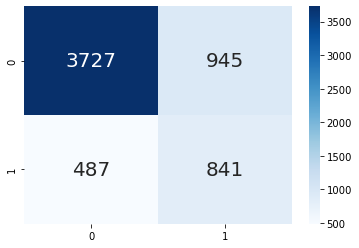

In [20]:
y_pre = clas_xgb2.predict(x_t)
cm = confusion_matrix(y_t, y_pre)
tn, fp, fn, tp = confusion_matrix(y_t, y_pre).ravel()

sns.heatmap(cm, cmap="Blues", fmt='g', annot=True, annot_kws={"size": 20})
acc_x=accuracy_score(y_t, y_pre)
acc_bx=balanced_accuracy_score(y_t, y_pre)
fn_x=round(fn / (fn + tp), 2)
print('Accuracy score: {0:0.4f}'. format(acc_x))
print('Balanced accuracy score: {0:0.4f}'. format(acc_bx))
print('False negative rate: {0:0.4f}'. format(fn_x))

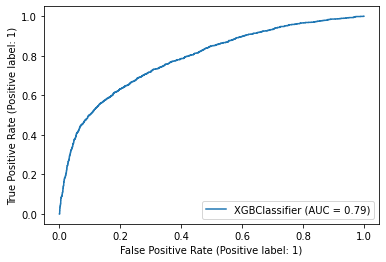

In [21]:
best_xgb = RocCurveDisplay.from_estimator(clas_xgb2, x_t, y_t)
plt.show()

In [212]:
res2=permutation_importance(clas_xgb2, x_tr, y_tr, scoring='roc_auc', random_state=seed)

In [213]:
importance2=pd.DataFrame(data=res2.importances_mean, index=x_tr.columns, columns=['importances mean'])
importance2['importances std']=res2.importances_std
importance2=importance.sort_values('importances mean', ascending=False)
imp2_10=importance.head(10)

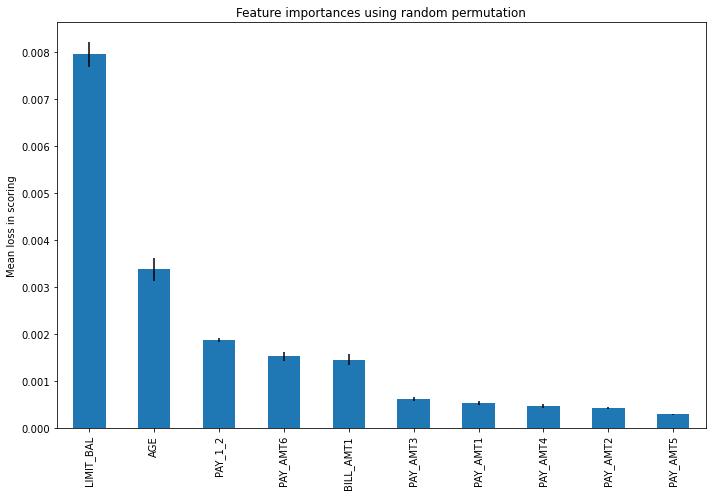

In [217]:
xgb_importance = pd.Series(imp2_10['importances mean'].values, index=imp2_10.index)
fig, ax = plt.subplots(figsize=(10,7))
xgb_importance.plot.bar(yerr=imp2_10['importances std'].values, ax=ax)
ax.set_title("Feature importances using random permutation")
ax.set_ylabel("Mean loss in scoring")
fig.tight_layout()

## CatBoost classifier

In [31]:
y = model_dt['default payment next month']
x =model_dt.drop('default payment next month',axis=1)
x_tr, x_t, y_tr, y_t = train_test_split(x, y, test_size=0.2, random_state=seed)
cat_features = list(range(0, x.shape[1]))
print(cat_features)

### Training

In [32]:
clas_cat=CatBoostClassifier(random_seed=seed, cat_features=cat_features, early_stopping_rounds=30)
clas_cat.fit(x_tr, y_tr, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy score: 0.8238
Balanced accuracy score: 0.6605
False negative rate: 0.6300


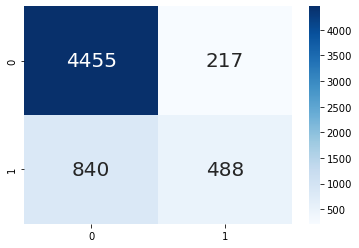

In [33]:
y_pre = clas_cat.predict(x_t)
cm = confusion_matrix(y_t, y_pre)
tn, fp, fn, tp = confusion_matrix(y_t, y_pre).ravel()

sns.heatmap(cm, cmap="Blues", fmt='g', annot=True, annot_kws={"size": 20})
print('Accuracy score: {0:0.4f}'. format(accuracy_score(y_t, y_pre)))
print('Balanced accuracy score: {0:0.4f}'. format(balanced_accuracy_score(y_t, y_pre)))
print('False negative rate: {0:0.4f}'. format(round(fn / (fn + tp), 2)))

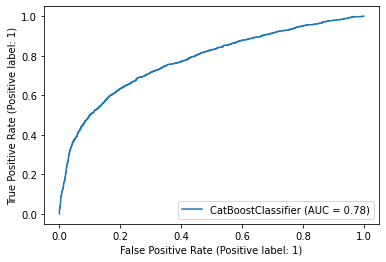

In [57]:
best_xgb = RocCurveDisplay.from_estimator( clas_cat, x_t, y_t)
plt.show()

In [ ]:
scale_pos_weight=weight
learning_rate': 0.04002099856734276

### Tuning

In [37]:
print(clas_cat.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'od_pval': 0, 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'l2_leaf_reg': 3, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:C

In [48]:
grid_search3={'depth':[2,3,4],
             'l2_leaf_reg':[4,5,6,7]
             }

search3=GridSearchCV(estimator=clas_cat2, param_grid=grid_search3, scoring='roc_auc', cv=5, n_jobs=-1)
search3.fit(x_tr, y_tr, verbose=False)

0:	learn: 0.6436195	total: 9.62ms	remaining: 14.4s
1:	learn: 0.6139976	total: 18.9ms	remaining: 14.1s
2:	learn: 0.6014200	total: 28.7ms	remaining: 14.3s
3:	learn: 0.5899349	total: 40.6ms	remaining: 15.2s
4:	learn: 0.5839760	total: 50.5ms	remaining: 15.1s
5:	learn: 0.5798085	total: 60.8ms	remaining: 15.1s
6:	learn: 0.5766593	total: 70.8ms	remaining: 15.1s
7:	learn: 0.5749712	total: 81ms	remaining: 15.1s
8:	learn: 0.5737304	total: 91.8ms	remaining: 15.2s
9:	learn: 0.5730893	total: 102ms	remaining: 15.2s
10:	learn: 0.5718861	total: 111ms	remaining: 15.1s
11:	learn: 0.5705731	total: 121ms	remaining: 15s
12:	learn: 0.5697917	total: 132ms	remaining: 15.1s
13:	learn: 0.5688611	total: 143ms	remaining: 15.2s
14:	learn: 0.5683099	total: 153ms	remaining: 15.2s
15:	learn: 0.5678328	total: 163ms	remaining: 15.1s
16:	learn: 0.5670006	total: 175ms	remaining: 15.3s
17:	learn: 0.5661739	total: 188ms	remaining: 15.4s
18:	learn: 0.5658792	total: 200ms	remaining: 15.6s
19:	learn: 0.5655779	total: 210ms	re

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000206B7971430>,
             n_jobs=-1,
             param_grid={'depth': [2, 3, 4], 'l2_leaf_reg': [4, 5, 6, 7]},
             scoring='roc_auc')

In [50]:
search3.best_params_

{'depth': 2, 'l2_leaf_reg': 7}

In [23]:
clas_cat2=CatBoostClassifier(random_seed=seed, iterations= 1500, learning_rate=0.3, depth= 2, l2_leaf_reg= 7, scale_pos_weight=weight, early_stopping_rounds=30)
clas_cat2.fit(x_tr, y_tr, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Testing

Accuracy score: 0.7555
Balanced accuracy score: 0.7128
False negative rate: 0.3600


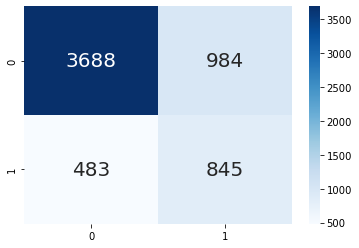

In [24]:
y_pre2 = clas_cat2.predict(x_t)
cm = confusion_matrix(y_t, y_pre2)
tn, fp, fn, tp = confusion_matrix(y_t, y_pre2).ravel()

sns.heatmap(cm, cmap="Blues", fmt='g', annot=True, annot_kws={"size": 20})
acc_c=accuracy_score(y_t, y_pre2)
acc_bc=balanced_accuracy_score(y_t, y_pre2)
fn_c=round(fn / (fn + tp), 2)
print('Accuracy score: {0:0.4f}'. format(acc_c))
print('Balanced accuracy score: {0:0.4f}'. format(acc_bc))
print('False negative rate: {0:0.4f}'. format(fn_c))

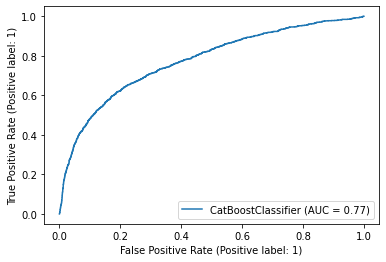

In [25]:
best_xgb = RocCurveDisplay.from_estimator(clas_cat2, x_t, y_t)
plt.show()

In [94]:
res3=permutation_importance(clas_cat2, x_tr, y_tr, scoring='roc_auc', random_state=seed)

In [95]:
importance3=pd.DataFrame(data=res3.importances_mean, index=x_tr.columns, columns=['importances mean'])
importance3['importances std']=res3.importances_std
importance3=importance3.sort_values('importances mean', ascending=False)
importance3_10=importance3.head(10)

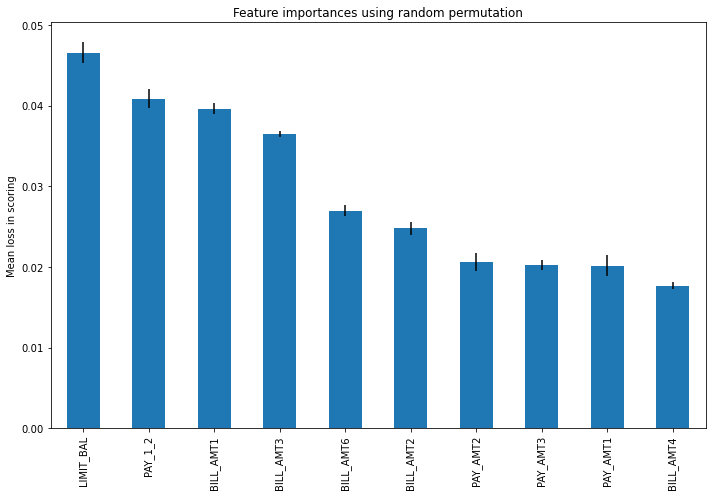

In [96]:
cat_importance = pd.Series(importance3_10['importances mean'].values, index=importance3_10.index)
fig, ax = plt.subplots(figsize=(10,7))
cat_importance.plot.bar(yerr=importance3_10['importances std'].values, ax=ax)
ax.set_title("Feature importances using random permutation")
ax.set_ylabel("Mean loss in scoring")
fig.tight_layout()

## Results

In [26]:
result_report = pd.DataFrame({'Metrics': ['Accuracy', acc_f, acc_x, acc_c],
                                'Model': ['', 'RandForest', 'XGBoost', 'CatBoost'],
                                     '': ['FNR', fn_f, fn_x, fn_c]})

result_report=result_report.set_index('Model')
result_report.insert(1,'',['Balanced Accuracy', acc_bf, acc_bx, acc_bc], True)
result_report.insert(3,'',[' AUC', 0.76 , 0.79, 0.76], True)
result_report

,Metrics,,,
Model,,,,
,Accuracy,Balanced Accuracy,FNR,AUC
RandForest,0.813667,0.646689,0.66,0.76
XGBoost,0.761333,0.715507,0.37,0.79
CatBoost,0.7555,0.712839,0.36,0.76
